In [49]:
# load required libraries
import pandas as pd
import numpy as np
from scipy.stats import t
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set_palette('GnBu_d')
from copy import copy

In [34]:
# import data
players = pd.read_csv('data/premier_league_players.csv', index_col='playerId')
events = pd.read_csv('data/premier_league_events.csv')

In [4]:
events.head()

,matchId,matchPeriod,id,eventSec,start_x,start_y,end_x,end_y,eventId,eventName,...,clearance,slidingTackle,redCard,yellowCard,secondYellowCard,accurate,inaccurate,counterAttack,dangerousBallLost,blocked
0,2499719,1H,177959171,2.758649,49,49,31,78,8,Pass,...,0,0,0,0,0,1,0,0,0,0
1,2499719,1H,177959172,4.946850,31,78,51,75,8,Pass,...,0,0,0,0,0,1,0,0,0,0
2,2499719,1H,177959173,6.542188,51,75,35,71,8,Pass,...,0,0,0,0,0,1,0,0,0,0
3,2499719,1H,177959174,8.143395,35,71,41,95,8,Pass,...,0,0,0,0,0,1,0,0,0,0
4,2499719,1H,177959175,10.302366,41,95,72,88,8,Pass,...,0,0,0,0,0,1,0,0,0,0


## Is Mo Salah's avg y position different from everyone else?

#### H0: Mo Salah shoots the ball from the same y position as everyone else.
#### H1: Mo Salah shoots the ball from a different y position than everyone else

To evaluate this we will assume Mo Salah is independent of the rest of the field and complete an independent t-test. Before we get to the t-test, however, let's take a look at the distributions.

In [105]:
# create a dataframe of all shots
# filter out corner kicks/penalty kicks (y==0, y==100)
shots_df = events[(events.eventName == 'Shot') & (events.start_y < 100) & (events.start_y > 0)]

# find mo salah's player ID
mo_id = players[players.shortName == 'Mohamed Salah'].index[0]
# slice the events df to only keep shots by mo salah
mo_shots = shots_df[shots_df.playerId == mo_id]

# subset the shots df to exclude observations involving mo salah
shots_no_mo = shots_df[shots_df.playerId != mo_id]

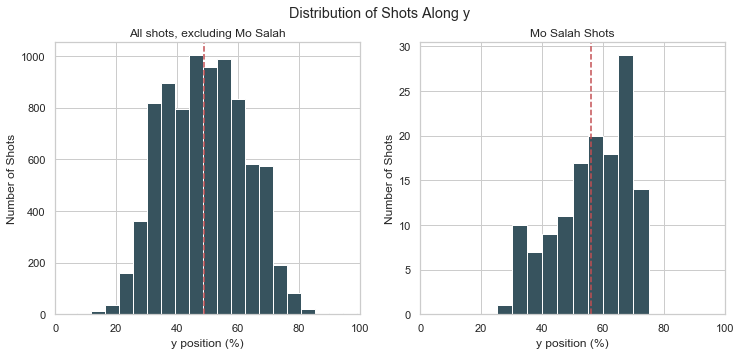

In [114]:
# initialize subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# add title to subplots
fig.suptitle('Distribution of Shots Along y')

# create histogram of all shots not involving mo
ax1.hist(shots_no_mo.start_y, bins=20)
# add title, x/y labels, and limits
ax1.set_title('All shots, excluding Mo Salah')
ax1.set_xlabel('y position (%)')
ax1.set_xlim(0, 100)
ax1.set_ylabel('Number of Shots')
shots_mean_y = np.mean(shots_no_mo.start_y)
# add vertical line at mean
ax1.axvline(shots_mean_y, color='r', linestyle = '--')

# create histogram of all mo salah shots
ax2.hist(mo_shots.start_y, bins=10)
# add title, x/y labels, and limits
ax2.set_title('Mo Salah Shots')
ax2.set_xlabel('y position (%)')
ax2.set_xlim(0, 100)
ax2.set_ylabel('Number of Shots')
mo_mean_y = np.mean(mo_shots.start_y)
# add vertical line at mean
ax2.axvline(mo_mean_y, color='r', linestyle = '--')

plt.show()

In the histograms above, 0 represents the right sideline if you are facing the goal and 100 represents the left sideline. The positions are shown as a percentage of the field width. It appears that the mean of all players excluding Mo Salah is close to 50% while Mo is biased towards the left side of the goal. 

Now lets run the t-test to see if this difference is significant. Typically normality is assumed when running a t-test. This assumption seems to hold for all shots, but when looking at Mo exclusively the distribution is not as normally distributed. In this case we will overlook the less than ideal distribution because t-tests are robust to violations of the normality assumption. To read more about this robustness, check out [this link](https://blog.minitab.com/blog/understanding-statistics-and-its-application/what-should-i-do-if-my-data-is-not-normal-v2). 


In [78]:
# calculate the t statistic and p value between the two samples
t_stat, p_val = ttest_ind(mo_shots.start_y, shots_df.start_y)
print('t statistic:', t_stat)
print('p value:', p_val)

t statistic: 6.140147247988889
p value: 8.610519188761847e-10


The results of this test show a p value which is essentially 0 which makes a strong case for rejecting the null hypothesis. Let's take this a step further and compare the t-statistic to the critical t score. For this case we'll  set our confidence level to 0.95. 

In [111]:
# define probability
p = 0.95
# define degrees of freedom
df = len(shots_no_mo) + len(mo_shots) - 2
# retrieve value <= probability
t_critical = t.ppf(p, df)
print('critical t score:', t_critical)

critical t score: 1.6450339959007674


If we compare the t statisitic with the critical t score we find that 6.14 > 1.65 and we reject the null hypothesis. Thus we can conclude with 95% certainty that on average Mo Salah shoots the soccer ball from a different y position than everyone else. One possibile explanation for this may be that Salah prefers his left foot and thus plays to the left side of the goal where it is easier to control the ball and cross back toward the goal or the center of the field.